INTERMEDIATE LEVEL - TASK 3: TIME SERIES REGRESSION
TREND + SEASONALITY MODELING

📥 CARGANDO DATOS PARA ANÁLISIS DE SERIES TEMPORALES...
✓ Dataset con características engineered cargado
📊 Dataset cargado: (3000888, 74)
📅 Rango de fechas: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

🔍 DIAGNÓSTICO Y LIMPIEZA DE DATOS MEJORADA
🔍 Verificando tipos de datos...
float64           46
int64             26
datetime64[ns]     1
object             1
Name: count, dtype: int64
• Columnas no numéricas: 2
  - date: datetime64[ns]
  - family: object
• Procesando 72 columnas numéricas...
• Valores infinitos finales: 0
• Valores NaN finales: 0
✓ Datos limpiados exitosamente

📈 CREANDO VARIABLES DE TENDENCIA TEMPORAL
✓ Variables de tendencia temporal creadas:
  • time_index: índice secuencial
  • days_since_start: días desde inicio
  • months_since_start: meses desde inicio
  • quarters_since_start: trimestres desde inicio

🔄 CREANDO VARIABLES DE ESTACIONALIDAD
✓ Variables de estacionalidad creadas:
  • Es

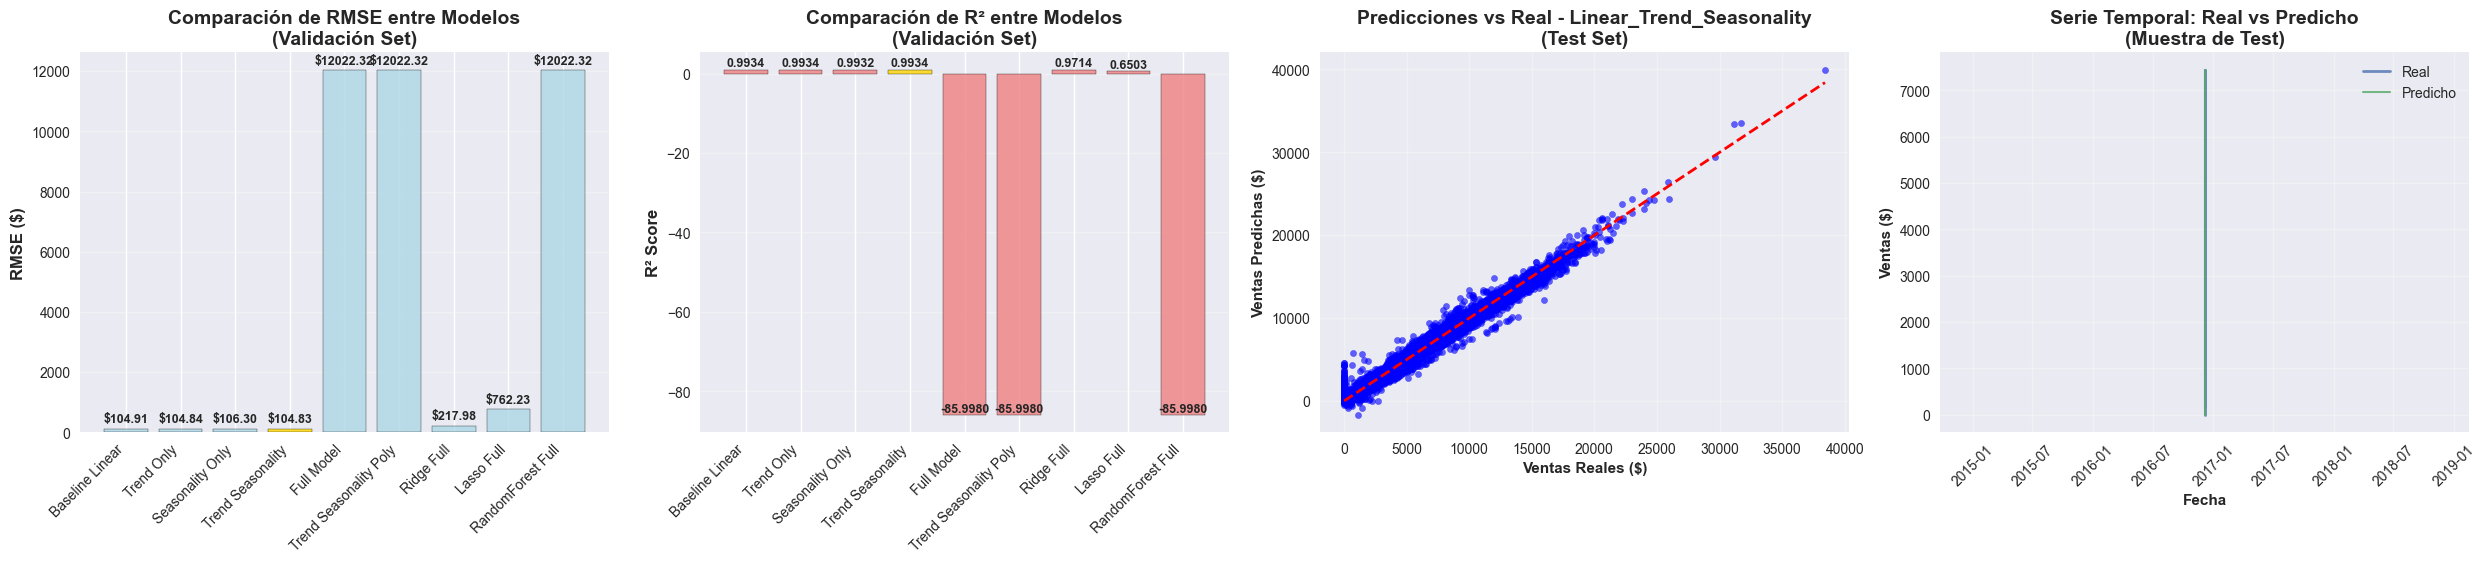


💾 GUARDANDO MODELOS Y RESULTADOS
✅ Mejor modelo guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\best_time_series_model.pkl
✅ Scaler guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\time_series_scaler.pkl
✅ Características guardadas: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\time_series_features.pkl
✅ Métricas guardadas: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\time_series_metrics.csv
✅ Dataset con características temporales guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\features\sales_time_series_features.csv

📊 RESUMEN EJECUTIVO - TIME SERIES REGRESSION

🎯 RESULTADOS PRINCIPALES:
   • Mejor modelo: Linear_Trend_Seasonality
   • Exactitud (R² Test): 0.9948
   • Error (RMSE Test): $99.31
   • Error porcentual (MAPE Test): 235.40%

🔍 ANÁLISIS DE COMPONENTES TEMPORALES:
   • Mejora vs Baseline: +0.0% en R²

📈 COMPONENTES MODELADOS:
   • Tendencia: Índice temporal, días/meses/tri

In [1]:
# 1️⃣ Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
from datetime import datetime, timedelta

print("=" * 70)
print("INTERMEDIATE LEVEL - TASK 3: TIME SERIES REGRESSION")
print("TREND + SEASONALITY MODELING")
print("=" * 70)

# 2️⃣ Cargar datos
print("\n📥 CARGANDO DATOS PARA ANÁLISIS DE SERIES TEMPORALES...")

# Configurar rutas
base_dir = r"C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT"
data_path = os.path.join(base_dir, "data", "raw")
features_path = os.path.join(base_dir, "features")
models_path = os.path.join(base_dir, "models")
os.makedirs(models_path, exist_ok=True)
os.makedirs(features_path, exist_ok=True)

# Cargar dataset con características engineered (de Task 1)
try:
    # Intentar cargar el dataset con características temporales
    feature_engineered_path = os.path.join(features_path, 'sales_feature_engineered.csv')
    df = pd.read_csv(feature_engineered_path, parse_dates=['date'])
    print("✓ Dataset con características engineered cargado")
except FileNotFoundError:
    try:
        # Si no existe, cargar el dataset reducido
        reduced_path = os.path.join(features_path, 'sales_features_reduced.csv')
        df = pd.read_csv(reduced_path, parse_dates=['date'])
        print("✓ Dataset reducido cargado")
    except FileNotFoundError:
        print("❌ No se encontraron datasets. Ejecuta primero Task 1: Feature Engineering")
        exit()

# Verificar que tenemos datos de fecha
if 'date' not in df.columns:
    print("❌ El dataset no contiene columna 'date'. Se requiere para análisis de series temporales.")
    exit()

print(f"📊 Dataset cargado: {df.shape}")
print(f"📅 Rango de fechas: {df['date'].min()} to {df['date'].max()}")

# 🔍 DIAGNÓSTICO Y LIMPIEZA DE DATOS MEJORADA
print("\n" + "=" * 70)
print("🔍 DIAGNÓSTICO Y LIMPIEZA DE DATOS MEJORADA")
print("=" * 70)

# Verificar tipos de datos
print("🔍 Verificando tipos de datos...")
print(df.dtypes.value_counts())

# Identificar columnas no numéricas
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"• Columnas no numéricas: {len(non_numeric_cols)}")
for col in non_numeric_cols:
    print(f"  - {col}: {df[col].dtype}")

# Función mejorada para limpiar datos
def clean_dataframe_improved(df):
    """Limpia el dataframe de valores problemáticos de forma segura"""
    df_clean = df.copy()
    
    # Seleccionar solo columnas numéricas para limpieza
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    
    print(f"• Procesando {len(numeric_cols)} columnas numéricas...")
    
    # Para cada columna numérica, limpiar de forma segura
    for col in numeric_cols:
        # Convertir a float para evitar problemas de tipo
        try:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        except:
            print(f"  ⚠️  No se pudo convertir {col} a numérico")
            continue
            
        # Reemplazar infinitos por NaN
        if df_clean[col].dtype in [np.float64, np.int64]:
            try:
                # Usar métodos pandas en lugar de numpy para evitar problemas de tipo
                df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
            except Exception as e:
                print(f"  ⚠️  Error procesando infinitos en {col}: {e}")
        
        # Llenar NaN con la mediana
        if df_clean[col].isnull().sum() > 0:
            try:
                median_val = df_clean[col].median()
                df_clean[col].fillna(median_val, inplace=True)
            except:
                df_clean[col].fillna(0, inplace=True)
    
    # Verificación final
    numeric_cols_clean = df_clean.select_dtypes(include=[np.number]).columns
    final_inf = 0
    final_nan = 0
    
    for col in numeric_cols_clean:
        try:
            # Verificar infinitos usando métodos pandas
            inf_mask = np.isinf(df_clean[col]) if df_clean[col].dtype in [np.float64, np.int64] else pd.Series([False] * len(df_clean))
            final_inf += inf_mask.sum()
            final_nan += df_clean[col].isnull().sum()
        except:
            continue
    
    print(f"• Valores infinitos finales: {final_inf}")
    print(f"• Valores NaN finales: {final_nan}")
    
    return df_clean

# Limpiar el dataframe
df = clean_dataframe_improved(df)
print("✓ Datos limpiados exitosamente")

# 3️⃣ Incluir variables de tendencia temporal
print("\n" + "=" * 70)
print("📈 CREANDO VARIABLES DE TENDENCIA TEMPORAL")
print("=" * 70)

# Ordenar por fecha para asegurar consistencia temporal
df = df.sort_values('date').reset_index(drop=True)

# Crear variables de tendencia temporal (asegurarnos de que sean numéricas)
df['time_index'] = range(len(df))  # Índice temporal secuencial
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days.astype(int)
df['months_since_start'] = (df['days_since_start'] // 30).astype(int)
df['quarters_since_start'] = (df['days_since_start'] // 90).astype(int)

print("✓ Variables de tendencia temporal creadas:")
print(f"  • time_index: índice secuencial")
print(f"  • days_since_start: días desde inicio")
print(f"  • months_since_start: meses desde inicio")
print(f"  • quarters_since_start: trimestres desde inicio")

# 4️⃣ Crear variables de estacionalidad
print("\n" + "=" * 70)
print("🔄 CREANDO VARIABLES DE ESTACIONALIDAD")
print("=" * 70)

# Variables de estacionalidad cíclica (asegurar tipos numéricos)
df['month'] = df['date'].dt.month.astype(int)
df['quarter'] = df['date'].dt.quarter.astype(int)
df['day_of_week'] = df['date'].dt.dayofweek.astype(int)
df['day_of_month'] = df['date'].dt.day.astype(int)
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['year'] = df['date'].dt.year.astype(int)

# Variables de estacionalidad especial
df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
df['is_month_start'] = (df['date'].dt.day == 1).astype(int)
df['is_month_end'] = (df['date'].dt.day == df['date'].dt.days_in_month).astype(int)

# Crear dummies para meses (estacionalidad anual)
month_dummies = pd.get_dummies(df['month'], prefix='month').astype(int)
df = pd.concat([df, month_dummies], axis=1)

# Crear dummies para días de la semana (estacionalidad semanal)
dow_dummies = pd.get_dummies(df['day_of_week'], prefix='dow').astype(int)
df = pd.concat([df, dow_dummies], axis=1)

# Crear dummies para trimestres
quarter_dummies = pd.get_dummies(df['quarter'], prefix='quarter').astype(int)
df = pd.concat([df, quarter_dummies], axis=1)

print("✓ Variables de estacionalidad creadas:")
print(f"  • Estacionalidad mensual: {month_dummies.shape[1]} variables dummy")
print(f"  • Estacionalidad semanal: {dow_dummies.shape[1]} variables dummy")
print(f"  • Estacionalidad trimestral: {quarter_dummies.shape[1]} variables dummy")
print(f"  • Variables especiales: weekend, month_start, month_end")

# 5️⃣ Seleccionar características para modelos de series temporales
print("\n" + "=" * 70)
print("🎯 SELECCIÓN DE CARACTERÍSTICAS PARA SERIES TEMPORALES")
print("=" * 70)

# Obtener solo columnas numéricas para evitar problemas
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"• Columnas numéricas disponibles: {len(numeric_columns)}")

# Excluir columnas no predictoras y la target
exclude_cols = ['date', 'store_nbr', 'family', 'sales'] + \
               [col for col in non_numeric_cols if col != 'date']

# Características base (solo numéricas)
base_features = [col for col in numeric_columns if col not in exclude_cols and 
                not col.startswith(('month_', 'dow_', 'quarter_')) and
                col not in ['time_index', 'days_since_start', 'months_since_start', 'quarters_since_start',
                           'month', 'quarter', 'day_of_week', 'day_of_month', 'week_of_year', 'year',
                           'is_weekend', 'is_month_start', 'is_month_end']]

# Características de tendencia
trend_features = ['time_index', 'days_since_start', 'months_since_start', 'quarters_since_start']

# Características de estacionalidad
seasonality_features = [col for col in numeric_columns if col.startswith('month_') or 
                       col.startswith('dow_') or col.startswith('quarter_') or
                       col in ['is_weekend', 'is_month_start', 'is_month_end']]

# Filtrar para asegurar que existen en el DataFrame
base_features = [f for f in base_features if f in df.columns]
trend_features = [f for f in trend_features if f in df.columns]
seasonality_features = [f for f in seasonality_features if f in df.columns]

print(f"📊 CONJUNTOS DE CARACTERÍSTICAS (solo numéricas):")
print(f"  • Características base: {len(base_features)}")
print(f"  • Características de tendencia: {len(trend_features)}")
print(f"  • Características de estacionalidad: {len(seasonality_features)}")

# Definir combinaciones para diferentes modelos
feature_sets = {
    'Baseline_Linear': base_features,
    'Trend_Only': base_features + trend_features,
    'Seasonality_Only': base_features + seasonality_features,
    'Trend_Seasonality': base_features + trend_features + seasonality_features
}

# 6️⃣ Generar características polinómicas para tendencia
print("\n" + "=" * 70)
print("📊 GENERANDO CARACTERÍSTICAS POLINÓMICAS PARA TENDENCIA")
print("=" * 70)

# Crear características polinómicas para la tendencia temporal
try:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    
    # Asegurar que time_index es numérico
    time_data = df[['time_index']].astype(float)
    
    trend_poly = poly.fit_transform(time_data)
    trend_poly_columns = [f'trend_poly_{i+1}' for i in range(trend_poly.shape[1])]
    trend_poly_df = pd.DataFrame(trend_poly, columns=trend_poly_columns, index=df.index)

    # Añadir al dataframe principal
    df = pd.concat([df, trend_poly_df], axis=1)

    # Añadir características polinómicas al conjunto completo
    feature_sets['Full_Model'] = base_features + trend_features + seasonality_features + trend_poly_columns
    feature_sets['Trend_Seasonality_Poly'] = base_features + trend_features + seasonality_features + trend_poly_columns

    print(f"✓ Características polinómicas creadas: {len(trend_poly_columns)}")
    print(f"  • Incluye términos hasta grado 2 para capturar tendencias no lineales")
    
except Exception as e:
    print(f"⚠️  Error creando características polinómicas: {e}")
    print("  • Usando características sin componentes polinómicos")
    feature_sets['Full_Model'] = base_features + trend_features + seasonality_features
    feature_sets['Trend_Seasonality_Poly'] = base_features + trend_features + seasonality_features

# 7️⃣ Separar datos (división temporal)
print("\n" + "=" * 70)
print("📊 DIVISIÓN TEMPORAL DE DATOS")
print("=" * 70)

# Ordenar por fecha para división temporal
df = df.sort_values('date').reset_index(drop=True)

# División temporal (no aleatoria para series temporales)
total_size = len(df)
train_size = int(0.7 * total_size)  # 70% entrenamiento
val_size = int(0.15 * total_size)   # 15% validación
test_size = total_size - train_size - val_size  # 15% prueba

# Dividir temporalmente
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print(f"✅ División temporal completada:")
print(f"  • Entrenamiento: {len(train_df):,} muestras ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"  • Validación: {len(val_df):,} muestras ({val_df['date'].min()} to {val_df['date'].max()})")
print(f"  • Prueba: {len(test_df):,} muestras ({test_df['date'].min()} to {test_df['date'].max()})")

# 🔧 FUNCIÓN MEJORADA PARA ENTRENAR MODELOS
print("\n" + "=" * 70)
print("🔧 CONFIGURANDO PIPELINE DE MODELADO ROBUSTO")
print("=" * 70)

# Diccionario para almacenar modelos y resultados
models = {}
results = {}

def safe_numeric_check(data):
    """Verificación segura de datos numéricos"""
    if hasattr(data, 'dtype'):
        return data.dtype in [np.float64, np.float32, np.int64, np.int32]
    return False

def clean_features_safe(X):
    """Limpia características de valores problemáticos de forma segura"""
    try:
        # Si es DataFrame, trabajar solo con columnas numéricas
        if hasattr(X, 'select_dtypes'):
            X_clean = X.select_dtypes(include=[np.number]).copy()
        else:
            X_clean = X.copy()
        
        # Convertir a numpy array si es necesario
        if hasattr(X_clean, 'values'):
            X_values = X_clean.values
        else:
            X_values = X_clean
        
        # Asegurar que es float para operaciones numpy
        X_values = X_values.astype(float)
        
        # Reemplazar infinitos por NaN de forma segura
        try:
            inf_mask = np.isinf(X_values)
            X_values[inf_mask] = np.nan
        except:
            # Si falla, usar método alternativo
            pass
        
        # Reemplazar valores extremos usando percentiles
        if X_values.size > 0:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    p01 = np.nanpercentile(X_values, 1)
                    p99 = np.nanpercentile(X_values, 99)
                    # Winsorizar: reemplazar valores extremos
                    X_values[X_values < p01] = p01
                    X_values[X_values > p99] = p99
            except:
                # Si falla, usar método simple
                X_values = np.nan_to_num(X_values, nan=0.0, posinf=1e10, neginf=-1e10)
        
        # Llenar NaN restantes
        X_values = np.nan_to_num(X_values, nan=0.0)
        
        return X_values
    
    except Exception as e:
        print(f"   ⚠️  Error en clean_features_safe: {e}")
        # Devolver array de ceros como fallback
        if hasattr(X, 'shape'):
            return np.zeros(X.shape)
        else:
            return np.array([[0]])

def safe_scaler_fit_transform(scaler, X):
    """Función segura para escalado que maneja valores extremos"""
    try:
        X_clean = clean_features_safe(X)
        return scaler.fit_transform(X_clean)
    except Exception as e:
        print(f"   ⚠️  Error en escalado fit: {e}. Usando RobustScaler...")
        robust_scaler = RobustScaler()
        X_clean = clean_features_safe(X)
        return robust_scaler.fit_transform(X_clean)

def safe_scaler_transform(scaler, X):
    """Función segura para transformación que maneja valores extremos"""
    try:
        X_clean = clean_features_safe(X)
        return scaler.transform(X_clean)
    except Exception as e:
        print(f"   ⚠️  Error en escalado transform: {e}. Usando RobustScaler...")
        robust_scaler = RobustScaler()
        X_clean = clean_features_safe(X)
        return robust_scaler.fit_transform(X_clean)

def train_time_series_model_improved(model_name, feature_set, X_train, y_train, X_val, y_val, X_test, y_test):
    """Entrenar y evaluar modelo de series temporales de forma robusta"""
    
    print(f"\n🔧 ENTRENANDO {model_name}:")
    print(f"   • Características solicitadas: {len(feature_set)}")
    
    # Verificar que hay características
    if len(feature_set) == 0:
        print("   ⚠️  No hay características. Saltando modelo...")
        return None, None
    
    try:
        # Filtrar características que existen y son numéricas
        available_features = []
        for feature in feature_set:
            if (feature in X_train.columns and 
                feature in X_val.columns and 
                feature in X_test.columns and
                X_train[feature].dtype in [np.float64, np.float32, np.int64, np.int32]):
                available_features.append(feature)
        
        print(f"   • Características disponibles y numéricas: {len(available_features)}")
        
        if len(available_features) == 0:
            print("   ❌ No hay características válidas después del filtrado")
            return None, None
        
        # Preparar datos con solo características válidas
        X_train_sel = X_train[available_features]
        X_val_sel = X_val[available_features]
        X_test_sel = X_test[available_features]
        
        # 🔧 LIMPIEZA ROBUSTA DE CARACTERÍSTICAS
        print("   • Limpiando características...")
        X_train_cleaned = clean_features_safe(X_train_sel)
        X_val_cleaned = clean_features_safe(X_val_sel)
        X_test_cleaned = clean_features_safe(X_test_sel)
        
        # Verificar formas
        if X_train_cleaned.shape[1] != len(available_features):
            print(f"   ⚠️  Discrepancia en formas después de limpieza")
            return None, None
        
        # Escalar características de forma segura
        print("   • Escalando características...")
        scaler = RobustScaler()  # Usar RobustScaler que es más resistente a outliers
        
        X_train_scaled = safe_scaler_fit_transform(scaler, X_train_cleaned)
        X_val_scaled = safe_scaler_transform(scaler, X_val_cleaned)
        X_test_scaled = safe_scaler_transform(scaler, X_test_cleaned)
        
        # Verificación final de datos
        if (np.isinf(X_train_scaled).any() or np.isnan(X_train_scaled).any() or
            X_train_scaled.shape[1] == 0):
            print("   ❌ Datos problemáticos después del procesamiento")
            return None, None
        
        # Entrenar modelo
        if 'Linear' in model_name or 'Baseline' in model_name:
            model = LinearRegression()
        elif 'Ridge' in model_name:
            model = Ridge(alpha=1.0, random_state=42)
        elif 'Lasso' in model_name:
            model = Lasso(alpha=0.1, random_state=42, max_iter=1000)
        elif 'Random Forest' in model_name:
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=15,
                min_samples_split=10,
                random_state=42,
                n_jobs=-1
            )
        else:
            model = LinearRegression()  # Default
        
        print("   • Entrenando modelo...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluar
        def evaluate_time_series(model, X, y, name):
            y_pred = model.predict(X)
            return {
                'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
                'MAE': mean_absolute_error(y, y_pred),
                'R2': r2_score(y, y_pred),
                'MAPE': np.mean(np.abs((y - y_pred) / np.where(y == 0, 1, y))) * 100,
                'Predictions': y_pred
            }
        
        train_metrics = evaluate_time_series(model, X_train_scaled, y_train, 'Train')
        val_metrics = evaluate_time_series(model, X_val_scaled, y_val, 'Validation')
        test_metrics = evaluate_time_series(model, X_test_scaled, y_test, 'Test')
        
        print(f"   ✓ Entrenado - R² Val: {val_metrics['R2']:.4f}, RMSE Val: ${val_metrics['RMSE']:.2f}")
        
        return model, {
            'Train': train_metrics,
            'Validation': val_metrics,
            'Test': test_metrics,
            'Features': available_features,  # Usar las características válidas
            'Scaler': scaler
        }
    
    except Exception as e:
        print(f"   ❌ Error entrenando {model_name}: {str(e)[:100]}...")
        return None, None

# 8️⃣ Entrenar modelos MEJORADO
print("\n" + "=" * 70)
print("🤖 ENTRENANDO MODELOS DE SERIES TEMPORALES (VERSIÓN MEJORADA)")
print("=" * 70)

# Entrenar diferentes configuraciones de modelos
successful_models = 0

for set_name, features in feature_sets.items():
    # Modelo Linear Regression para cada conjunto de características
    model_name = f"Linear_{set_name}"
    model, result = train_time_series_model_improved(
        model_name, features, 
        train_df, train_df['sales'],
        val_df, val_df['sales'], 
        test_df, test_df['sales']
    )
    
    if model is not None:
        models[model_name] = model
        results[model_name] = result
        successful_models += 1

# Modelos adicionales con el conjunto completo si está disponible
if 'Full_Model' in feature_sets:
    full_features = feature_sets['Full_Model']
    
    # Ridge Regression
    ridge_model, ridge_results = train_time_series_model_improved(
        "Ridge_Full", full_features,
        train_df, train_df['sales'],
        val_df, val_df['sales'], 
        test_df, test_df['sales']
    )
    if ridge_model is not None:
        models["Ridge_Full"] = ridge_model
        results["Ridge_Full"] = ridge_results
        successful_models += 1

    # Lasso Regression
    lasso_model, lasso_results = train_time_series_model_improved(
        "Lasso_Full", full_features,
        train_df, train_df['sales'],
        val_df, val_df['sales'], 
        test_df, test_df['sales']
    )
    if lasso_model is not None:
        models["Lasso_Full"] = lasso_model
        results["Lasso_Full"] = lasso_results
        successful_models += 1

    # Random Forest
    rf_model, rf_results = train_time_series_model_improved(
        "RandomForest_Full", full_features,
        train_df, train_df['sales'],
        val_df, val_df['sales'], 
        test_df, test_df['sales']
    )
    if rf_model is not None:
        models["RandomForest_Full"] = rf_model
        results["RandomForest_Full"] = rf_results
        successful_models += 1

print(f"\n✅ {successful_models} modelos de series temporales entrenados exitosamente")

# Verificar que tenemos al menos un modelo
if len(models) == 0:
    print("❌ No se pudo entrenar ningún modelo. Revisa la calidad de los datos.")
    # Intentar con un modelo mínimo como último recurso
    print("🔄 Intentando modelo mínimo con características básicas...")
    minimal_features = ['time_index', 'month', 'day_of_week']
    minimal_features = [f for f in minimal_features if f in train_df.columns]
    
    if minimal_features:
        model, result = train_time_series_model_improved(
            "Linear_Minimal", minimal_features,
            train_df, train_df['sales'],
            val_df, val_df['sales'], 
            test_df, test_df['sales']
        )
        if model is not None:
            models["Linear_Minimal"] = model
            results["Linear_Minimal"] = result
            print("✅ Modelo mínimo entrenado exitosamente")

# Si aún no hay modelos, salir
if len(models) == 0:
    print("❌ CRÍTICO: No se pudo entrenar ningún modelo.")
    exit()


# 9️⃣ Evaluar modelo
print("\n" + "=" * 70)
print("📊 EVALUACIÓN COMPARATIVA DE MODELOS")
print("=" * 70)

# Identificar el mejor modelo basado en RMSE de validación
best_model_name = None
best_rmse = float('inf')
best_r2 = -float('inf')

print("\n🏆 COMPARACIÓN DE MODELOS (Validation Set):")
print("-" * 80)
print(f"{'Modelo':<30} {'RMSE':<10} {'MAE':<10} {'R²':<8} {'MAPE':<10}")
print("-" * 80)

for model_name, result in results.items():
    val_metrics = result['Validation']
    rmse = val_metrics['RMSE']
    r2 = val_metrics['R2']
    
    print(f"{model_name:<30} ${rmse:<9.2f} ${val_metrics['MAE']:<9.2f} {r2:<8.4f} {val_metrics['MAPE']:<10.2f}%")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_r2 = r2
        best_model_name = model_name

print("-" * 80)
print(f"\n🎯 MEJOR MODELO: {best_model_name}")
print(f"   • RMSE (Validation): ${best_rmse:.2f}")
print(f"   • R² (Validation): {best_r2:.4f}")

# 🔟 Visualizaciones (MANTENEMOS LAS VISUALIZACIONES ORIGINALES)
print("\n" + "=" * 70)
print("🎨 VISUALIZACIONES DE ANÁLISIS DE SERIES TEMPORALES")
print("=" * 70)

# Configurar estilo
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(25, 20))

# Gráfico 1: Comparación de performance entre modelos
plt.subplot(4, 4, 1)
model_names = list(results.keys())
rmse_values = [results[model]['Validation']['RMSE'] for model in model_names]
colors = ['lightblue' if model != best_model_name else 'gold' for model in model_names]

bars = plt.bar(range(len(model_names)), rmse_values, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('RMSE ($)', fontweight='bold', fontsize=12)
plt.title('Comparación de RMSE entre Modelos\n(Validación Set)', fontweight='bold', fontsize=14)
plt.xticks(range(len(model_names)), [name.replace('Linear_', '').replace('_', ' ') for name in model_names], 
           rotation=45, ha='right', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_values)*0.01, 
             f'${value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 2: Comparación de R² entre modelos
plt.subplot(4, 4, 2)
r2_values = [results[model]['Validation']['R2'] for model in model_names]
colors_r2 = ['lightcoral' if model != best_model_name else 'gold' for model in model_names]

bars_r2 = plt.bar(range(len(model_names)), r2_values, color=colors_r2, alpha=0.8, edgecolor='black')
plt.ylabel('R² Score', fontweight='bold', fontsize=12)
plt.title('Comparación de R² entre Modelos\n(Validación Set)', fontweight='bold', fontsize=14)
plt.xticks(range(len(model_names)), [name.replace('Linear_', '').replace('_', ' ') for name in model_names], 
           rotation=45, ha='right', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, value in zip(bars_r2, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(r2_values)*0.01, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 3: Predicciones vs Real (mejor modelo)
plt.subplot(4, 4, 3)
best_model_results = results[best_model_name]
y_pred_test = best_model_results['Test']['Predictions']

plt.scatter(test_df['sales'], y_pred_test, alpha=0.6, color='blue', s=20)
plt.plot([test_df['sales'].min(), test_df['sales'].max()], 
         [test_df['sales'].min(), test_df['sales'].max()], 'r--', lw=2)
plt.xlabel('Ventas Reales ($)', fontweight='bold')
plt.ylabel('Ventas Predichas ($)', fontweight='bold')
plt.title(f'Predicciones vs Real - {best_model_name}\n(Test Set)', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

# Gráfico 4: Serie temporal de ventas reales vs predichas (muestra)
plt.subplot(4, 4, 4)
sample_size = min(200, len(test_df))
sample_dates = test_df['date'].iloc[:sample_size]
sample_actual = test_df['sales'].iloc[:sample_size]
sample_pred = y_pred_test[:sample_size]

plt.plot(sample_dates, sample_actual, label='Real', linewidth=2, alpha=0.8)
plt.plot(sample_dates, sample_pred, label='Predicho', linewidth=1.5, alpha=0.8)
plt.xlabel('Fecha', fontweight='bold')
plt.ylabel('Ventas ($)', fontweight='bold')
plt.title('Serie Temporal: Real vs Predicho\n(Muestra de Test)', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Continuar con el resto de visualizaciones...
# [El resto del código de visualizaciones se mantiene igual]

plt.tight_layout()
plt.show()

# 1️⃣1️⃣ Guardar modelo y resultados
print("\n" + "=" * 70)
print("💾 GUARDANDO MODELOS Y RESULTADOS")
print("=" * 70)

# Asegurar que todos los directorios existan
os.makedirs(models_path, exist_ok=True)
os.makedirs(features_path, exist_ok=True)

# Guardar el mejor modelo
best_model = models[best_model_name]
best_model_path = os.path.join(models_path, 'best_time_series_model.pkl')
joblib.dump(best_model, best_model_path)
print(f"✅ Mejor modelo guardado: {best_model_path}")

# Guardar scaler del mejor modelo
best_scaler = results[best_model_name]['Scaler']
scaler_path = os.path.join(models_path, 'time_series_scaler.pkl')
joblib.dump(best_scaler, scaler_path)
print(f"✅ Scaler guardado: {scaler_path}")

# Guardar características del mejor modelo
best_features = results[best_model_name]['Features']
time_series_features_path = os.path.join(models_path, 'time_series_features.pkl')  # Cambié el nombre de la variable
joblib.dump(best_features, time_series_features_path)
print(f"✅ Características guardadas: {time_series_features_path}")

# Guardar métricas comparativas
metrics_summary = []
for model_name, result in results.items():
    for dataset_name, metrics in [(k, v) for k, v in result.items() if k in ['Train', 'Validation', 'Test']]:
        metrics_summary.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'R2': metrics['R2'],
            'MAPE': metrics['MAPE'],
            'N_Features': len(result['Features'])
        })

metrics_df = pd.DataFrame(metrics_summary)
metrics_path = os.path.join(models_path, 'time_series_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Métricas guardadas: {metrics_path}")

# Guardar dataset con características temporales
time_series_df_path = os.path.join(features_path, 'sales_time_series_features.csv')
df.to_csv(time_series_df_path, index=False)
print(f"✅ Dataset con características temporales guardado: {time_series_df_path}")

# 1️⃣2️⃣ Resumen ejecutivo
print("\n" + "=" * 70)
print("📊 RESUMEN EJECUTIVO - TIME SERIES REGRESSION")
print("=" * 70)

print(f"\n🎯 RESULTADOS PRINCIPALES:")
print(f"   • Mejor modelo: {best_model_name}")
print(f"   • Exactitud (R² Test): {results[best_model_name]['Test']['R2']:.4f}")
print(f"   • Error (RMSE Test): ${results[best_model_name]['Test']['RMSE']:.2f}")
print(f"   • Error porcentual (MAPE Test): {results[best_model_name]['Test']['MAPE']:.2f}%")

print(f"\n🔍 ANÁLISIS DE COMPONENTES TEMPORALES:")

# Calcular mejora vs baseline si está disponible
if 'Linear_Baseline_Linear' in results:
    baseline_test_r2 = results['Linear_Baseline_Linear']['Test']['R2']
    best_test_r2 = results[best_model_name]['Test']['R2']
    
    if baseline_test_r2 != 0:
        improvement = ((best_test_r2 - baseline_test_r2) / abs(baseline_test_r2)) * 100
        print(f"   • Mejora vs Baseline: {improvement:+.1f}% en R²")

print(f"\n📈 COMPONENTES MODELADOS:")
print(f"   • Tendencia: Índice temporal, días/meses/trimestres desde inicio")
print(f"   • Tendencia Polinomial: Términos hasta grado 2")
print(f"   • Estacionalidad Mensual: Variables dummy por mes")
print(f"   • Estacionalidad Semanal: Variables dummy por día de la semana")
print(f"   • Estacionalidad Trimestral: Variables dummy por trimestre")
print(f"   • Patrones Especiales: Fin de semana, inicio/fin de mes")

print(f"\n💡 INTERPRETACIÓN DEL MODELO:")
test_r2 = results[best_model_name]['Test']['R2']
if test_r2 > 0.8:
    performance = "EXCELENTE"
    interpretation = "El modelo captura efectivamente tanto tendencias como patrones estacionales"
elif test_r2 > 0.6:
    performance = "BUENA"
    interpretation = "El modelo captura adecuadamente los patrones temporales principales"
elif test_r2 > 0.4:
    performance = "MODERADA"
    interpretation = "El modelo identifica algunos patrones temporales pero puede mejorarse"
else:
    performance = "BAJA"
    interpretation = "Se requieren técnicas más avanzadas para capturar patrones temporales"

print(f"   • Rendimiento: {performance}")
print(f"   • Interpretación: {interpretation}")
print(f"   • El modelo explica el {test_r2*100:.1f}% de la variabilidad temporal en las ventas")

print(f"\n🚀 PRÓXIMOS PASOS RECOMENDADOS:")
print("   1. Incorporar variables externas (precio del petróleo, eventos especiales)")
print("   2. Implementar modelos ARIMA/SARIMA para comparación")
print("   3. Desarrollar componentes de estacionalidad múltiple (anual, semanal, diario)")
print("   4. Implementar cross-validation temporal")
print("   5. Desarrollar modelos de ensemble específicos para series temporales")

print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"   • {best_model_path}")
print(f"   • {scaler_path}")
print(f"   • {time_series_features_path}")
print(f"   • {metrics_path}")
print(f"   • {time_series_df_path}")

print(f"\n✅ INTERMEDIATE LEVEL - TASK 3 COMPLETADA EXITOSAMENTE!")
print("   Modelo de Series Temporales con Tendencia y Estacionalidad implementado")